In [1]:
import pandas as pd
import numpy as np
import kaggle
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

%matplotlib inline

In [2]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('titanic', path='./titanic_data')

with zipfile.ZipFile('./titanic_data/titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./titanic_data')

os.remove('./titanic_data/titanic.zip')

In [20]:
train_df = pd.read_csv('./titanic_data/train.csv')
test_df = pd.read_csv('./titanic_data/test.csv')

In [21]:
train_df = train_df[['Survived', 'Pclass', 'Sex', 'Fare']]

train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

print(train_df.head(15))

    Survived  Pclass  Sex     Fare
0          0       3    0   7.2500
1          1       1    1  71.2833
2          1       3    1   7.9250
3          1       1    1  53.1000
4          0       3    0   8.0500
5          0       3    0   8.4583
6          0       1    0  51.8625
7          0       3    0  21.0750
8          1       3    1  11.1333
9          1       2    1  30.0708
10         1       3    1  16.7000
11         1       1    1  26.5500
12         0       3    0   8.0500
13         0       3    0  31.2750
14         0       3    1   7.8542


---

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
parametrs = {
    'n_estimators': [i for i in range(1, 16)],  
    'max_depth': [i for i in range(1, 11)]  
}

x_train = train_df[['Pclass', 'Sex', 'Fare']]
y_train = train_df.Survived


grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(x_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 5}

In [36]:
x_test = test_df[['Pclass', 'Sex', 'Fare']]
x_test['Sex'] = x_test['Sex'].map({'male': 0, 'female': 1})

/var/folders/d0/71gb2rzn4w16ky59sf35r4zr0000gn/T/ipykernel_4181/3294117734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Sex'] = x_test['Sex'].map({'male': 0, 'female': 1})


In [37]:
# Получить предсказания и вероятности
predictions = grid_search_cv_clf.predict(x_test)
probabilities = grid_search_cv_clf.predict_proba(x_test)

# Создать полный DataFrame с результатами
results_df = test_df.copy()  # Копируем исходные признаки из тестовой выборки

# Добавить предсказания
results_df['Prediction'] = predictions

# Добавить вероятности для каждого класса
results_df['Prob_Not_Survived'] = probabilities[:, 0]  # Вероятность класса 0 (не выжил)
results_df['Prob_Survived'] = probabilities[:, 1]      # Вероятность класса 1 (выжил)

In [38]:
results_df.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prediction,Prob_Not_Survived,Prob_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.865802,0.134198
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0.148594,0.851406
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.874928,0.125072
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.846965,0.153035
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.215377,0.784623
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,0.846965,0.153035
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,0.264145,0.735855
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,0.553333,0.446667
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,0.230811,0.769189
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,0.971875,0.028125


In [39]:
# Лучшие параметры
print("Лучшие параметры:", grid_search_cv_clf.best_params_)

# Лучший score на кросс-валидации
print("Лучший CV score:", grid_search_cv_clf.best_score_)

Лучшие параметры: {'max_depth': 7, 'n_estimators': 5}
Лучший CV score: 0.8159939740129308


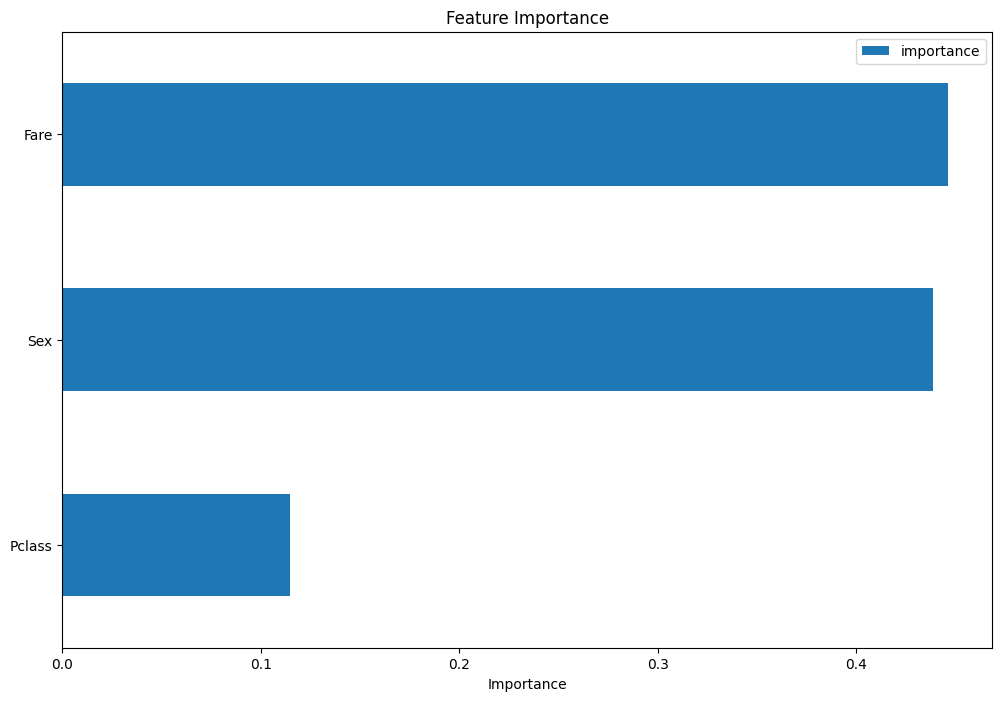

In [40]:
import matplotlib.pyplot as plt

best_model = grid_search_cv_clf.best_estimator_

imp = pd.DataFrame(best_model.feature_importances_,
                   index=x_train.columns,
                   columns=['importance'])

imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

---

In [41]:
import shutil

folder_path = './titanic_data'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder {folder_path} succeful delited")
else:
    print(f"Folder {folder_path} does not exist")

Folder ./titanic_data succeful delited
